## Set up the environment

In [1]:
N_JOBS = 12

In [2]:
from joblib import Parallel, delayed
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from tqdm import tqdm
tqdm.pandas()
from tqdm.auto import tqdm as tn
        
from functools import partial
from sklearn.metrics import mean_squared_error

rmse = partial(mean_squared_error, squared=False)

In [3]:
path = "data/pti/"
train_path = path + 'train_data.csv'
test_path = path + 'test_data_full.csv'
sample_path = path +'test_data_check_template.csv'

sample = pd.read_csv(sample_path)

train_raw = pd.read_csv(train_path, index_col=0, parse_dates=['CreatedDate', 'CreatedDateForInsert', 'PrevOpportunityStageUpdate', 'ValidThroughDate'])
test_raw = pd.read_csv(test_path, index_col=0, parse_dates=['CreatedDate', 'CreatedDateForInsert', 'PrevOpportunityStageUpdate', 'ValidThroughDate'])

train_raw['is_train'] = 1
test_raw['is_train'] = 0

all_df = pd.concat([train_raw, test_raw])
print(len(all_df))
all_df = all_df.drop_duplicates(keep='first', subset=set(all_df.columns) - {'is_train'})
print(len(all_df))

all_df['orig_index'] = all_df.index
all_df['is_test'] = all_df['Id'].isin(sample['Id']).astype('int')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning:

Columns (14,32) have mixed types.Specify dtype option on import or set low_memory=False.



38851
34991


## Preprocessing & Feature engineering

In [4]:
def basic_prep(X):
    # Sort dataframe by time
    X = X.sort_values(['CreatedDateForInsert', 'orig_index'])
    # drop duplicate cols
    X = X.drop(columns=["SystemModstamp", "PrevOpportunityStageUpdate"])
    # drop all columns with too many Nans
    X = X.drop(columns=["PrevAmount", "PrevCloseDate"])
    # all the same values
    X = X.drop(columns=["IsDeleted", "Territory2Id", "PartnerAccountId"])
    
    X["LeadSource"] = X["LeadSource"].fillna("Other")
    X["Original_Lead_Source__c"] = X["Original_Lead_Source__c"].fillna("Other")
    
    # Notice that target is divided by 100 for the cross-entropy loss
    X['target'] = X.groupby('OpportunityId')['Probability'].shift(-1) / 100
    
    return X

In [5]:
def encode_prep(X: pd.DataFrame) -> pd.DataFrame:
    """
    Simply CountVectorizer, but for particular list columns
    """
    X = X[list_cols].copy()
    unique_needs = dict()
    for row in X["Needs__c"].dropna():
        split_needs = row.split(";")
        for el in split_needs:
            if el not in unique_needs.keys():
                unique_needs.update({el : 1})
            else:
                unique_needs[el] += 1
    unique_needs = pd.Series(unique_needs)
    needs_names = list(unique_needs.sort_values(ascending=False).index[:21])
    for idx, name in enumerate(needs_names):
        X[f"Need_{idx}"] = X["Needs__c"].str.contains(name).fillna(0).astype('int32')
    X = X.drop(columns=["Needs__c"])
    # Type_of_Users__c binary features
    unique_types = dict()
    for row in X["Type_of_Users__c"].dropna():
        split_types = row.split(";")
        for el in split_types:
            if el not in unique_types.keys():
                unique_types.update({el : 1})
            else:
                unique_types[el] += 1
    unique_types = pd.Series(unique_types)
    types_names = list(unique_types.sort_values(ascending=False).index[:2])
    for idx, name in enumerate(types_names):
        X[f"Type_of_Users_{idx}"] = X["Type_of_Users__c"].fillna(0).str.contains(name).fillna(0).astype('int32')
    X = X.drop(columns=["Type_of_Users__c"])
    return X

In [6]:
def get_date_features(X):
    orig_cols = date_cols
    df = pd.DataFrame(index=X.index)
    df['days_since_creation'] = (X['CreatedDateForInsert'] - X['CreatedDate']).dt.days
    df['days_valid_through'] = (X['ValidThroughDate'] - X['CreatedDateForInsert']).dt.days
    df['days_valid_through_since_creation'] = (X['ValidThroughDate'] - X['CreatedDate']).dt.days
    
    df['current_year'] = X['CreatedDateForInsert'].dt.year
    df['current_quarter'] = X['CreatedDateForInsert'].dt.quarter
    
    date = (X['CreatedDateForInsert'].dt.dayofyear - 1) / 365
    df['current_dayofyear_sin'] = np.sin(2 * np.pi * date)
    df['current_dayofyear_cos'] = np.cos(2 * np.pi * date)
    return df

In [7]:
def get_lag_features(X):
    df = pd.DataFrame(index=X.index)
    df['prev_prob'] = X.groupby('OpportunityId')['Probability'].shift(1)
    df['prob_delta'] = X.groupby('OpportunityId')['Probability'].diff(1)
    
    df['prev_row'] = X.groupby('OpportunityId')['CreatedDateForInsert'].diff(1).dt.days
    df['prev_row_manager'] = X.groupby('CreatedById')['CreatedDateForInsert'].diff(1).dt.days
    
    df['prev_prob_mean'] = X.groupby('OpportunityId')['Probability'].transform(lambda x: x.expanding().mean())
    df['prev_prob_std'] = X.groupby('OpportunityId')['Probability'].transform(lambda x: x.expanding().mean())
    df['prev_prob_min'] = X.groupby('OpportunityId')['Probability'].transform(lambda x: x.expanding().min())
    df['prev_prob_max'] = X.groupby('OpportunityId')['Probability'].transform(lambda x: x.expanding().max())
    df['prev_prob_count'] = X.groupby('OpportunityId')['Probability'].transform(lambda x: x.expanding().count())
    
    df['prev_manager_std_5'] = X.groupby('CreatedById')['Probability'].transform(lambda x: x.rolling(5).std())
    df['prev_manager_std_10'] = X.groupby('CreatedById')['Probability'].transform(lambda x: x.rolling(10).std())
    
    df['prev_manager_kurt_5'] = X.groupby('CreatedById')['Probability'].transform(lambda x: x.rolling(5).kurt())
    df['prev_manager_kurt_10'] = X.groupby('CreatedById')['Probability'].transform(lambda x: x.rolling(10).kurt())
    
    yyyymm = X['CreatedDateForInsert'].dt.year*100 + X['CreatedDateForInsert'].dt.month
    yyyy = X['CreatedDateForInsert'].dt.year
    
    df['prev_month_num_opports'] = X.groupby(yyyymm)['Probability'].nunique().shift(1)
    df['prev_year_num_opports'] = X.groupby(yyyy)['Probability'].nunique().shift()
    
    df['prev_month_mean_proba'] = X.groupby(yyyymm)['Probability'].mean().shift(1)
    df['prev_year_mean_proba'] = X.groupby(yyyy)['Probability'].mean().shift()
    
    df['prev_month_std_proba'] = X.groupby(yyyymm)['Probability'].std().shift(1)
    df['prev_year_std_proba'] = X.groupby(yyyy)['Probability'].std().shift()
    
    return df
    

In [8]:
all_df = basic_prep(all_df)

id_cols = ['Id', 'OpportunityId', 'is_train', 'is_test']
list_cols = ["Needs__c", "Type_of_Users__c"]
numeric_cols = ['Amount', 'Probability', 'StageSortOrder', 'FiscalYear', 'FiscalQuarter', 'Number_of_Seats__c']
binary_cols = ['SCC_Interest__c']
cat_cols = ['CreatedById', 'AccountId',
            'RecordTypeId', 'Type', 'LeadSource', 'CampaignId',
            'OwnerId', 'Company_s_CRM_Type__c', 'Deal_type__c',
            'TAM__c', 'Secondary_CSM__c', 'Source_Type__c',
            'Original_Lead_Source__c', 'Original_Lead_Source_Details__c',
            'OpportunityId'
           ]
date_cols = ['CreatedDate', 'CreatedDateForInsert', 'ValidThroughDate']

In [9]:
# create features

test_idx = all_df['is_test'] == 1
train_idx = all_df['is_train'] == 1

X = pd.concat([
    all_df[numeric_cols + binary_cols],
    all_df[cat_cols],
    get_date_features(all_df),
    encode_prep(all_df),
    get_lag_features(all_df)
], axis=1)

y = all_df['target']

X[cat_cols] = X[cat_cols].fillna('NaN')  # for catboost
X[cat_cols] = X[cat_cols].astype('category')
orig_dtypes = X.dtypes

/tmp/ipykernel_32392/4270429515.py:17: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [10]:
# create basic train/test split
X_train, y_train = X[train_idx], y[train_idx]
X_test = X[test_idx]

time_train = all_df.loc[train_idx, 'CreatedDateForInsert']
time_test = all_df.loc[test_idx, 'CreatedDateForInsert']

In [11]:
# create train for the classifier

good_stages = ['Won', '100% Won / PO / Invoiced']
bad_stages = ['Lost', '0% probability Closed Lost Refunded', '0% probability Closed Expired', '0% probability Closed Lost']

classifier_labels = X_train.copy()#[['Id', 'StageName']]
classifier_labels['time'] = time_train
classifier_labels.loc[all_df.loc[train_idx, 'StageName'].isin(bad_stages), 'labels'] = 0
classifier_labels.loc[all_df.loc[train_idx, 'StageName'].isin(good_stages), 'labels'] = 1
classifier_labels = classifier_labels.dropna(subset=['labels'])
time_classifier = classifier_labels['time']
X_classifier = classifier_labels.drop(columns=['labels', 'time'])
y_classifier = classifier_labels['labels']

## Training

### Functions

In [12]:
def extract_prediction(results):
    '''
    For the given iterable of results from the "time_respecting_prediction"
    return np.ndarray of predictions and pd.DataFrame of average feature importance
    '''
    ps = []
    fis = []
    for p, fi in results:
        ps.append(p)
        fis.append(fi)

    preds = ps
    preds = np.hstack(preds)
    preds = np.clip(preds, 0, 1)
    
    fi = pd.DataFrame(fis).mean().sort_values(ascending=False)#.iloc[:50]
    return preds, fi


def time_respecting_prediction(row, time, estimator,
                               preprocessing=lambda x, y: (x, y),
                               importance=lambda x: x.feature_importances_,
                               all_X_train=X_train,
                               all_y_train=y_train,
                               all_time_train=time_train
                               ):
    '''
    fits estimator on train rows before given time
    Returns prediction for row and estimator's feature importance
    '''
    fold_idx = all_time_train < time
    X_fold, y_fold = all_X_train[fold_idx], all_y_train[fold_idx]
    X_fold, y_fold = X_fold[~y_fold.isna()], y_fold[~y_fold.isna()]
    
    X_fold, y_fold = preprocessing(X_fold, y_fold)
    
    row = pd.DataFrame(row).T
    row, _ = preprocessing(row, None)
    row = row.astype(X_fold.dtypes)

    
    if len(X_fold) < 10:
        print("no train available")
        return np.nan, [np.nan] * len(X_fold.columns)
    
    estimator.fit(X_fold, y_fold)
    return estimator.predict(row), importance(estimator)

In [13]:
from catboost import CatBoost
from lightgbm import LGBMRegressor

catboost_params = {
    'cat_features': cat_cols,
    'random_seed': 45,
    # 'loss_function': 'RMSE',
    'loss_function': 'RMSE',
    'n_estimators': 100,
    "has_time": True,
    'silent': True,
    'thread_count': 1,
    
}
lightgbm_params = {
    'n_jobs': 1, 
    'use_missing': True,
    'random_seed': 45,
    'objective': 'cross_entropy',
    'n_estimators': 100
}


cb = CatBoost(catboost_params)
lgbm = LGBMRegressor(**lightgbm_params)


estimators = {
    'cb': {
        'estimator': cb,
        'importance': lambda x: x.get_feature_importance()
    },
    'lightgbm': {
        'estimator': lgbm
    }
}

### Train classifier

In [14]:
# create classifier prediction for all the given data
# about 36 minutes to run on n_jobs=32...

classifier_train = {
    'all_X_train': X_classifier,
    'all_y_train': y_classifier,
    'all_time_train': time_classifier
}


results = Parallel(N_JOBS)(
    delayed(time_respecting_prediction)(row, time, **estimators['lightgbm'], **classifier_train)
    for (_, row), time in zip(X.iterrows(), tn(all_df['CreatedDateForInsert']))
)

  0%|          | 0/34991 [00:00<?, ?it/s]

In [15]:
cpreds, _ = extract_prediction(results)
pd.to_pickle(cpreds, 'classifier_stage.pkl')

In [16]:
# results = Parallel(N_JOBS)(delayed(time_respecting_prediction)(row, time, **estimators['cb']) for (i, row), time in zip(X_test.iterrows(), tn(time_test)))
# preds, fi = extract_prediction(results)

# y_true = y[test_idx]
# rmse(y_true, preds) * 100

### Preparation

In [17]:
cpreds = pd.read_pickle('classifier_stage.pkl')
cpreds = pd.Series(cpreds).fillna(0.5).values

### Train LGBMs

In [18]:
gt5_filter = (cpreds>=0.5)[train_idx]
gt5_train = {
    'all_X_train': X_train[gt5_filter],
    'all_y_train': y_train[gt5_filter],
    'all_time_train': time_train[gt5_filter]
}


lt5_filter = (cpreds<0.5)[train_idx]
lt5_train = {
    'all_X_train': X_train[lt5_filter],
    'all_y_train': y_train[lt5_filter],
    'all_time_train': time_train[lt5_filter]
}


In [19]:
results_gt5_lg = Parallel(N_JOBS)(
    delayed(time_respecting_prediction)(row, time, **estimators['lightgbm'], **gt5_train)
    for (i, row), time in zip(X_test.iterrows(), tn(time_test))
)
results_lt5_lg = Parallel(N_JOBS)(
    delayed(time_respecting_prediction)(row, time, **estimators['lightgbm'], **lt5_train)
    for (i, row), time in zip(X_test.iterrows(), tn(time_test))
)

  0%|          | 0/3702 [00:00<?, ?it/s]

  0%|          | 0/3702 [00:00<?, ?it/s]

### Train Catboosts

In [20]:
from catboost import CatBoost

X_train = X_train.drop(columns=['OpportunityId'])
X_test = X_test.drop(columns=['OpportunityId'])
cat_cols = cat_cols[:-1]

gt5_filter = (cpreds>=0.5)[train_idx]
gt5_train = {
    'all_X_train': X_train[gt5_filter],
    'all_y_train': y_train[gt5_filter],
    'all_time_train': time_train[gt5_filter]
}


lt5_filter = (cpreds<0.5)[train_idx]
lt5_train = {
    'all_X_train': X_train[lt5_filter],
    'all_y_train': y_train[lt5_filter],
    'all_time_train': time_train[lt5_filter]
}


catboost_params = {
    'cat_features': cat_cols,
    'random_seed': 45,
    'loss_function': 'RMSE',
    'n_estimators': 100,
    "has_time": True,
    'silent': True,
    'thread_count': 1,
}

cb = CatBoost(catboost_params)

catboost = {
    'estimator': cb,
    'importance': lambda x: x.get_feature_importance()
}


results_gt5_cb = Parallel(N_JOBS)(
    delayed(time_respecting_prediction)(row, time, **catboost, **gt5_train)
    for (i, row), time in zip(X_test.iterrows(), tn(time_test))
)
results_lt5_cb = Parallel(N_JOBS)(
    delayed(time_respecting_prediction)(row, time, **catboost, **lt5_train)
    for (i, row), time in zip(X_test.iterrows(), tn(time_test))
)


  0%|          | 0/3702 [00:00<?, ?it/s]

  0%|          | 0/3702 [00:00<?, ?it/s]

### Stack together

In [21]:
preds5gt_lg, _ = extract_prediction(results_gt5_lg)
preds5lt_lg, _ = extract_prediction(results_lt5_lg)
preds5gt_cb, _ = extract_prediction(results_gt5_cb)
preds5lt_cb, _ = extract_prediction(results_lt5_cb)

In [22]:
preds5lt_lg = np.where(np.isnan(preds5lt_lg), preds5gt_lg, preds5lt_lg)
preds5lt_cb = np.where(np.isnan(preds5lt_cb), preds5gt_cb, preds5lt_cb)

comb_lg = np.where((cpreds>=0.5)[test_idx], preds5gt_lg, preds5lt_lg)
comb_cb = np.where((cpreds>=0.5)[test_idx], preds5gt_cb, preds5lt_cb)

In [23]:
y_true = y[test_idx]

In [24]:
rmse(y_true, comb_cb) * 100, rmse(y_true, comb_lg) * 100

(20.877274323286414, 20.72668380012609)

In [25]:
rmse(y_true, 0.6*comb_lg + 0.4*comb_cb) * 100

20.370326166655563

In [26]:
target_pred = pd.DataFrame({
    'Id': all_df.loc[test_idx, 'Id'],
    # 'target': y_true,
    'Probability': (0.6*comb_lg + 0.4*comb_cb)*100
})
target_pred.to_csv('fair_threshold_com_stage_class_stack_catboost.csv', index=False)

### Exploration

<AxesSubplot:xlabel='col', ylabel='distribution'>

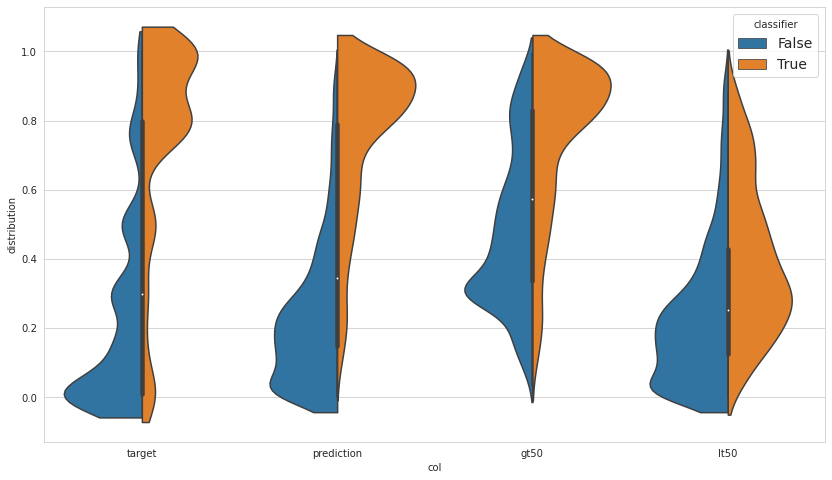

In [27]:
target_pred = pd.DataFrame({
    'target': y_true,
    'prediction': comb_lg,
    'gt50': preds5gt_lg,
    'lt50': preds5lt_lg,
    'classifier': (cpreds > 0.5)[test_idx]
})

pdfs = []
for col in ['target', 'prediction', 'gt50', 'lt50']:
    pdf = target_pred[[col, 'classifier']].rename(columns={col: 'distribution'})
    pdf['col'] = col
    pdfs.append(pdf)

pdfs = pd.concat(pdfs)

sns.violinplot(data=pdfs, cut=True, x='col', y='distribution', split=True, hue='classifier')

<AxesSubplot:>

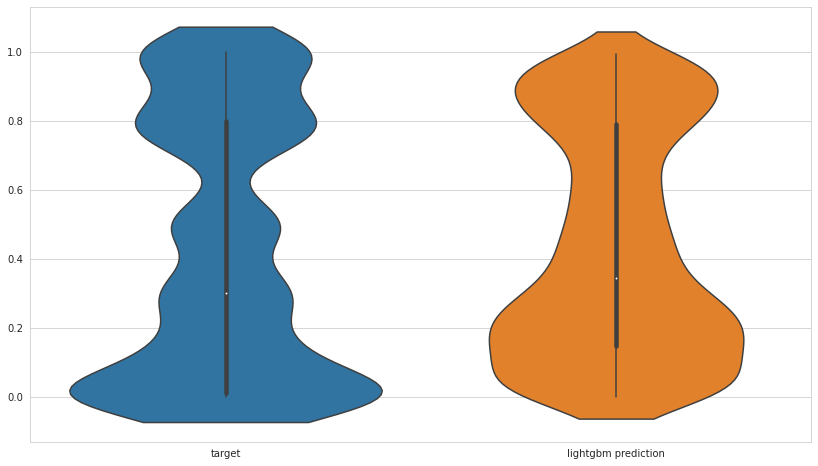

In [28]:
target_pred = pd.DataFrame({
    'target': y_true,
    'lightgbm prediction': comb_lg,
    # 'lgbm gt50': preds5gt_lg,
    # 'lgbm lt50': preds5lt_lg,
#     'catboost prediction': comb_cb,
    
#     'catboost gt50': preds5gt_cb,
#     'catboost lt50': preds5lt_cb,
    # 'classifier': (cpreds > 0.5)[test_idx]
})


sns.violinplot(data=target_pred, cut=True, )

<AxesSubplot:ylabel='Count'>

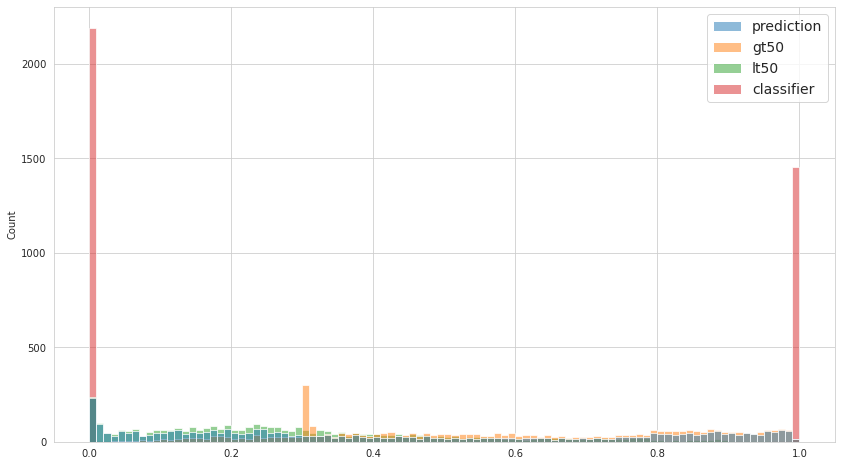

In [29]:
target_pred = pd.DataFrame({
    # 'Id': all_df.loc[test_idx, 'Id'],
    # 'target': y_true,
    'prediction': comb_lg,
    'gt50': preds5gt_lg,
    'lt50': preds5lt_lg,
    'classifier': (cpreds)[test_idx]
})

sns.histplot(data=target_pred, common_norm=True, bins=100)